## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> </center>
## <center> TP4 INF8460 <br>  Automne 2022 </center>

<b> Équipe 10 </b> <br/>
1904128 : Skander Soussou <br/>
1927506 : Benjamin-Ousmane M'Bengue <br/>
1951918 : Pierre-Luc Rivet <br/>
1960154 : Tommy Pou <br/>

---

Le présent Notebook a été exécuté avec :

In [ ]:
!python --version

## 1. DESCRIPTION

Dans ce TP, l’idée est d'utiliser un système de traduction automatique pour générer des requêtes de base de connaissances en SPARQL à partir de questions en langage naturel.

Les bases de connaissances sont une source de données structurées, selon les standards, modèles et langages du Web sémantique, qui permettent un accès efficace à une grande quantité d'information dans des domaines très variés. Cependant, leur accès est limité par la complexité des requêtes qui ne permet pas au public de s'en servir. Un système de traduction automatique pourrait permettre de générer automatiquement une requête étant donnée une question formulée par un usager en langage naturel.

Dans notre cas, la langue d’entrée sera l’anglais et le langage de requête sera SPARQL (https://www.w3.org/TR/sparql11-query/). Afin de faciliter le travail du modèle, nous vous fournissons une version modifiée des questions dans laquelle certains mots sont remplacés par leur équivalent que l’on retrouve dans la requête.

Voici un exemple : <br>

__Question originale :__ _In how many other states do people live, whose languages are spoken in apocalypto?_

__Entrée : Question taggée :__ _In how many other dbp:region do people live, whose dbo:language are spoken in dbr:Apocalypto?_

__Sortie attendue : Requête:__ _select distinct count ( ?uri ) where { dbr:Apocalypto dbo:language ?x . ?x dbp:region ?uri }_

(Cette demande revoie à la partie suivant de la base de connaissance DBPedia:

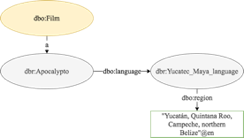

dbr:Apocalypto a dbo:Film . <br>
dbr:Apocalypto dbo:language dbr:Yucatec_Maya_language .  <br>
dbr:Yucatec_Maya_language dbp:region "Yucatán, Quintana Roo, Campeche, northern Belize"@en . )

__Réponse : 1__

## 2. LIBRARIES PERMISES

- Numpy
- Pandas
- HuggingFace
- Keras
- NLTK
- SPACY
- Pytorch
- re


- Pour toute autre librairie, demandez à votre chargé de laboratoire

## 3. INFRASTRUCTURE

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)
- Vous pouvez aussi utiliser l’environnement Google Colab :  https://colab.research.google.com/

## 4. ECHÉANCE

- Fin de la session. La date précise sera indiquée sur Moodle.

## 5. KAGGLE

Le TP4-projet se fera sous forme d’une compétition Kaggle.  Vous devrez utiliser l’environnement Kaggle pour la soumission et l’évaluation de vos modèles.  
Pour tester votre système au fur et à mesure, vous aurez le droit à 4 soumissions par jour sur Kaggle. Vous verrez deux types de résultats sur votre « private leaderboard » et votre « public leaderboard » :
- Le « public leaderboard » est calculé sur approximativement 30% des données de test, choisies aléatoirement par Kaggle. Ce score est public et est calculé sur la même tranche de donnée pour tous les participants. 
- Le « private leaderboard » est calculé sur approximativement 70% des données de test et n’est visible qu’à la fin de la compétition. Le résultat final sera basé sur ce leaderboard. Si aucune soumission n’est choisie, la soumission avec le meilleur score sur le « public leaderboard » sera utilisée pour calculer le score sur le « private leaderboard ».

Pour l’évaluation, vous devrez soumettre un fichier de données _tp4_submission.csv_ du même format que le fichier _sample_submission.csv_ (disponible sur le site de la compétition et Moodle). _tp4_submission.csv_ devra contenir pour chaque ligne de votre ensemble de test, la requête retournée par votre approche, selon le format indiqué dans la compétition.

## 6. DESCRIPTION DES DONNEES ET METRIQUES D’EVALUATION

Le corpus est un corpus de 5 000 paires de questions - requêtes sur DBPedia portant sur une grande variété de thèmes plus ou moins spécifiques. Trois documents sont fournis :

-	Les 4000 paires de questions – requêtes d’entrainement dans un fichier train.csv.
-	Les 500 paires de questions – requêtes de validation dans un fichier validation.csv.
-	Les 500 questions de test pour lesquelles vous devez générer des requêtes SPARQL dans un fichier test.csv.

La sortie de votre modèle sera comparée à notre ensemble de référence. Vous serez évalués en utilisant la métrique « accuracy » sur les requêtes prédites par vos modèles dans la compétition Kaggle. Cette métrique vérifie pour chaque requête prédite par votre modèle si elle est exactement égale à la requête attendue. Faite donc bien attention aux requêtes générées : un seul caractère non correct fait compter la requête comme fausse. 

Nous vous demandons également de rapporter, dans votre notebook uniquement, la métrique BLEU de votre modèle sur l’ensemble de validation. Cette métrique est très utilisée dans les tâches de traduction automatique et nous vous fournissons une fonction qui la calcule. Pour plus d’information voir https://en.wikipedia.org/wiki/BLEU.

## 7. ETAPES DU TP

À partir de ce notebook squelette, vous devez réaliser les étapes suivantes. (Notez que les cellules dans le squelette sont là à titre informatif il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

### 7.1. Etat de l’art (5%)

Décrivez en __deux paragraphes__, dans une cellule du notebook, avec les références appropriées, les architectures de l’état de l’art pour la génération de requêtes SPARQL. Utilisez le service Google Scholar. Voici quelques mots-clés : Neural Machine Translation SPARQL, SPARQL Sequence to Sequence Model, etc.

En vous basant sur vos recherches et sur cet article, quelles sont les meilleures techniques de l’état de l’art ?  Soyez brefs et clairs. Attention à comparer des approches sur les mêmes jeux de données et en utilisant les mêmes métriques dans votre analyse.

Nous avons trouvé une étude comparative qui évalue les performances des architectures de l'État de l’art pour la traduction du langage naturel en SPARQL. En effet le papier compare la perplexité, le blue score ainsi que le F1 scores de NSpM(Neural SPARQL Machines), GNMT-8( Google Neural Machine Translation), LSTM Luong, Transformer et une architecture encodeur-décodeur avec Conv2d.

Sur les Jeux de données de validation des questionnements et réponses Mon, Mon50, Mon80, LC-QUAD et DBNQA les trois meilleurs modèles sont:
- Le transformeur (architecture seq 2 seq) a un blue score moyen de 82.07
- Le LSTM avec Luong comme mécanisme d’attention a un blue score moyen de 82.25
- L’architecture encodeur-décodeur avec Conv2d à un blue score moyen de 89.16

La meilleure architecture de l’état de l’art pour la génération de requêtes SPARQL selon ce papier est une architecture encodeur-décodeur ou les deux sont composés de blocs convolutionnel empilés. Chaque bloc est composé d'une couche convolutionnelle unidimensionnelle suivie d'une couche linéaire(GLU).

Il est important de noter que tous les modèles utilisés dans ce papier ne sont pas pré-entraînés et donc il n’y a pas de fine-tuning. De plus, lors de nos recherches la majorité des modèles de l'état de l’art que nous avons trouvé utilisent des graph de dépendances. Nous avons donc jugé d'exclure ces derniers.

Article: https://www.sciencedirect.com/science/article/pii/S0167739X20330752?casa_token=1t64Eww0lmUAAAAA:uV3bCeSQc7HGpnaWzZdwCAnEb_sim-CRxjxdM5OlibvZ-0C9pZfcycxHnnUGkZspUDntzaPMqQ#b17

### 7.2. Méthodologie

#### 7.2.1. Architecture proposée (5%)

Proposez une architecture d'encodeur-décodeur non pré-entrainée de type Transformer ou CNN pour la tâche. Décrivez l’architecture et la méthodologie en quelques lignes dans une cellule de texte.

L'architecture que nous proposons est un réseau de neurones à convolutions (CNN) constitué d'encodeurs et de décodeurs. Il est fortement inspiré du modèle **ConvS2S *(Convolutional Sequence to Sequence Learning*)**. Le principe de cette architecure repose est représenté par le schéma suivant pour chaque encodeur et décodeur:

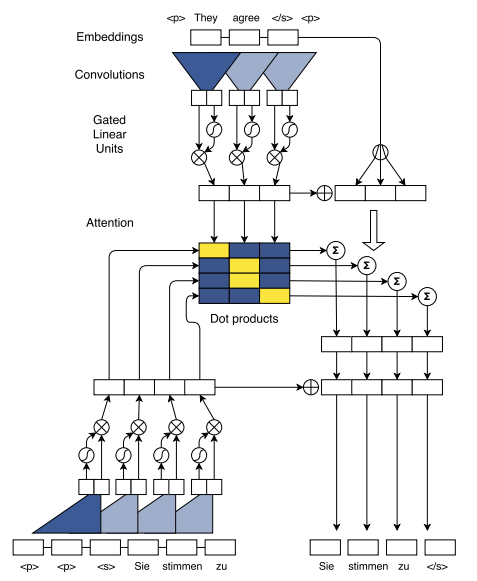

Tout d'abord, les entrées sont représentées dans des plongements des mots à l'aide d'une matrice de taille $[V * f]$, où $V$ est la taille du vocabulaire et $f$ est la taille du plongement. En plus des mots, on représente également les positions des mots à l'aide d'une matrice d'*embedding*. Les deux vecteurs sont ensuite combinés en une seule représentation à l'aide d'une somme $e = p_1+m1,...p_f+m_f $.

Ensuite, le plongement de taille $f$ passe à travers une couche cachée et devient de taille $h$ où $h$ est la taille de la couche cachée. Puis, l'entrée est mise dans la couche de convolutions. À la sortie de la couche de convolutions, on retrouve une fonction d'activation **GLU**, qui consiste en un *Gated linear unit*. 

La sortie du GLU est additionnée au plongement mis en entrée pour calculer la connection résiduelle. Le résultat de cette série d'opérations correspond à la sortie de l'encodeur.

Pour les décodeurs, les mêmes opérations sont effectuées. De plus, les valeurs de l'attention multi-tête sont calculées à l'aide des séquences du contexte. On effectue des produits scalaires entre la sortie du GLU et les valeurs obtenues en calculant l'attention pour déterminer la prochaine séquence à générer.

Référence:
Jonas Gehring, Michael Auli, David Grangier, Denis Yarats, and Yann N Dauphin. 2017. _Convolutional sequence to sequence learning_. arXiv preprint
arXiv:1705.03122.

#### 7.2.2. Mise en place (45%)

Mettez en place la solution proposée dans la partie précédente. 

Note: Le code est très fortement inspiré du projet suivant : <br />
[pytorch Seq2Seq - Convolutional Sequence to Sequence Learning](https://github.com/bentrevett/pytorch-seq2seq/blob/master/5%20-%20Convolutional%20Sequence%20to%20Sequence%20Learning.ipynb)

##### 7.2.2.0 Initialisation de l'environnement de travail

In [1]:
import random
import torch

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

##### 7.2.2.1 Chargement des données

In [2]:
# Retire le besoin de modifier la variable PATH. Tant que le script est exécuté depuis sa position
# dans le filesystem

import os
directory_path = os.getcwd()
PATH = directory_path + "/data/"

In [3]:
import pandas

# Chargement des fichiers d'entraînement et de tests.
train = pandas.read_csv(PATH + "train.csv")
valid = pandas.read_csv(PATH + "validation.csv")
test = pandas.read_csv(PATH + "test.csv")

In [4]:
train.head(10)

,id,english,sparql
0,0,how many movies are there whose dbo:director i...,select distinct count ( ?uri ) where { ?uri db...
1,1,what dbo:City 's dbo:founder is dbr:John_Forbe...,select distinct ?uri where { ?uri dbo:founder ...
2,2,what is the dbo:River whose dbo:riverMouth is ...,select distinct ?uri where { ?uri dbo:riverMou...
3,3,what is the dbp:allegiance of dbr:John_Kotelaw...,select distinct ?uri where { dbr:John_Kotelawa...
4,4,what is the total number of dbp:race of the ra...,select distinct count ( ?uri ) where { ?x dbo:...
5,5,what is the dbo:incumbent of the dbr:Al_Gore_p...,select distinct ?uri where { dbr:Al_Gore_presi...
6,6,what is the dbo:region of dbr:Tom_Perriello ?,select distinct ?uri where { dbr:Tom_Perriello...
7,7,what is the dbo:layout of the dbo:Automobile w...,select distinct ?uri where { ?x dbp:related db...
8,8,what is the dbp:address of the hotels whose db...,select distinct ?uri where { ?x dbp:operator d...
9,9,what is the dbp:mascot of dbr:Austin_College ?,select distinct ?uri where { dbr:Austin_Colleg...


##### 7.2.2.2 Pré-traitement

In [5]:
%%capture

import warnings
warnings.filterwarnings('ignore')


# Importing relevant packages

import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet = True)
stopwords = stopwords.words('english')

stemmer = nltk.stem.porter.PorterStemmer()

In [6]:
"""
    Fonction qui converti les tokens SPARQL dans un format qui évite
    la création de milliers de tokens distincts pour les variables
    recherchées.
    
    : @param df_input        : Le Dataframe à traiter
    : @param cols            : Liste de strings contenant les noms des colonnes à traiter
    : @param charPunctuation : Si la ponctuation attendue d'une requête SPARQL
                               doit être convertie en tokens textuels
    : @param keywordReplace  : Si les mots clés d'une requête SPARQL doivent
                               être convertis en tokens textuels
    : @return df             : Dataframe contenant les listes de jetons pré-traités
    : @return lookup         : Dictionnaires de traduction des tokens protégés
"""

SPARQL_reserved_keywords = {
    "ask" : "<ask>",
    "count" : "<count>",
    "distinct" : "<distinct>",
    "select" : "<select>",
    "where" : "<where>",
    "filter" : "<filter>",
    "group by" : "<group_by>",
    "limit" : "<limit>",
    "order by" : "<order_by>",
    "union" : "<union>"
}

SPARQL_operators = ["<count>"]

SPARQL_punctuation = {
    "." : " <sepdot> ",
    "{" : " <openBracket> ",
    "}" : " <closebracket> "
}

SPARQL_translation_dict = {
    "<sepdot>" : ".",
    "<openbracket>" : "{",
    "<closebracket>" : "}",
    "<ask>" : "ask",
    "<count>" : "count",
    "<distinct>" : "distinct",
    "<select>" : "select",
    "<where>" : "where",
    "<filter>" : "filter",
    "<group_by>" : "group by",
    "<limit>" : "limit",
    "<order_by>" : "order by",
    "<union>" : "union",
}

def SPARQL_tokens(df_input, cols, charPunctuation = False, keywordReplace = False) :
    df = df_input[cols].copy(deep = True)
    
    arr = df.to_numpy()
    lookup = pandas.DataFrame(columns = ["lookup"], index = list(range(len(df))))
    lookup.iloc[:, 0] = [{} for i in range(len(lookup))]
    
    # dbo:texte, dbp:texte, dbr:texte et rdf:type
    pattern = "(db.|rdf):(\S*)"
    
    # ?x, ( ?uri )
    pattern_var = "(?:\( )?(\?[A-Za-z0-9]+)(?: \))?"
    par_left = "(\( )?"
    par_right = "( \))?"
    
    for i in range(len(df_input)) :
        tokens = sorted(list(set(re.findall(pattern, " ".join(arr[i, :])))))
        var = list(set(re.findall(pattern_var, " ".join(arr[i, :]))))
        
        prev = ""
        offset = 0
        if(len(tokens) > 0) :
            for j in range(len(tokens)) :
                if(prev != tokens[j][0]) :
                    prev = tokens[j][0]
                    offset = j
                
                for k in range(len(cols)) :
                    arr[i, k] = re.sub(f" ({tokens[j][0]}):" + re.escape(tokens[j][1] + " "), f" <\g<1>_{j - offset}> ", arr[i, k])
                
                lookup.iloc[i, 0][f"<{tokens[j][0]}_{j - offset}>"] = f"{tokens[j][0]}:{tokens[j][1]}"
        
        if(len(var) > 0) :
            for j in range(len(var)) :
                for k in range(len(cols)) :
                    arr[i, k] = re.sub(par_left + re.escape(var[j]) + par_right, f"<var_{j}>", arr[i, k])
                
                lookup.iloc[i, 0][f"<var_{j}>"] = var[j]
        
    
    # Remplace les symboles de ponctuation associés aux requêtes SPARQL
    if(charPunctuation and "sparql" in cols) :
        for key in SPARQL_punctuation :
            df["sparql"] = df["sparql"].str.replace(key, SPARQL_punctuation[key])
    
    if(keywordReplace and "sparql" in cols) :
        for keyword in SPARQL_reserved_keywords.keys():
            df["sparql"] = df["sparql"].str.replace(keyword, SPARQL_reserved_keywords[keyword])
    
    return df, lookup

In [7]:
"""
    Fonction qui transforme un dataframe de chaînes de caractères en liste de
    jetons.
    
    Les étapes de pré-traitement à compléter sont les suivantes :
    1. Enlever les majuscules
    2. Enlever les caractères de ponctuations
    3. Séparer la chaine de caractères en une liste de jetons (tokenization) 
    4. Enlever les stopwords
    5. Stemming (racinisation)
    
    : @param df_input        : Le Dataframe à traiter
    : @param cols            : Liste de strings contenant les noms des colonnes à traiter
    : @param removeStopwords : Si les stopwords doivent être retirés
    : @param stemming        : Si la racinisation doit être appliquée
    : @param charPunctuation : Si la ponctuation attendue d'une requête SPARQL
                               doit être convertie en tokens textuels
    : @param keywordReplace  : Si les mots clés d'une requête SPARQL doivent
                               être convertis en tokens textuels
    : @return df             : Dataframe contenant les listes de jetons pré-traités
    : @return lookup         : Dictionnaires de traduction des tokens protégés
"""
def prepocessDataframeCols(df_input, cols, removeStopwords = False, stemming = False, charPunctuation = False, keywordReplace = False) :
    df = df_input[cols].copy(deep = True)
    
    # Retire les symboles de ponctuation associés aux tokens SPARQL qui vont être créés
    df = df.replace("[<>]", "", regex = True)
    
    df, lookup = SPARQL_tokens(df_input, cols, charPunctuation = charPunctuation, keywordReplace = keywordReplace)
    
    for col in cols :
        # Retire les majuscules
        df[col] = df[col].str.lower()
        
        # Retire la ponctuation en la remplaçant par des espaces et
        # en retirant ensuite les espaces doubles
        if(col == "sparql") :
            if(charPunctuation) :
                df[col] = df[col].str.replace("[^A-Za-z0-9<>_]", " ")
            else :
                df[col] = df[col].str.replace("[^A-Za-z0-9{}.<>_]", " ")
                df[col] = df[col].str.replace("([{}.])", " \g<1> ")
        else :
            df[col] = df[col].str.replace("[^A-Za-z0-9<>_]", " ")
        
        df[col] = df[col].str.replace("[ ]+", " ")
        
        # Sépare en jetons selon les espaces
        df[col] = df[col].str.split()
        
        if(removeStopwords or stemming) :
            for i in range(len(df[col])) :
                tokens = df[col].iloc[i]
                if(removeStopwords) :
                    filtered_tokens = []
                    for token in tokens :
                        if token not in stopwords :
                            filtered_tokens = filtered_tokens + [token]
                    
                    tokens = filtered_tokens
                
                if(stemming) :
                    tokens = [stemmer.stem(token) for token in tokens]
                
                df[col].iloc[i] = tokens
    
    return df, lookup

In [8]:
def joinTokens(df_input, cols) :
    df = df_input[cols].copy(deep = True)
    
    for col in cols :
        for i in range(len(df[col])) :
            df[col].iloc[i] = " ".join(df[col].iloc[i])
    
    return df

def splitTokens(x) :
    return x.split()

In [9]:
# On applique la fonction de prétraitement aux ensembles de données
cols = ["english", "sparql"]
tokens, lookup = prepocessDataframeCols(train, cols, charPunctuation = True, keywordReplace = True)
train["tokens"] = tokens["english"]
train["request"] = tokens["sparql"]
train["lookup"] = lookup["lookup"]

joinTokens(tokens, cols).to_csv(PATH + "train_tokens.csv")

tokens, lookup = prepocessDataframeCols(valid, cols, charPunctuation = True, keywordReplace = True)
valid["tokens"] = tokens["english"]
valid["request"] = tokens["sparql"]
valid["lookup"] = lookup["lookup"]

joinTokens(tokens, cols).to_csv(PATH + "valid_tokens.csv")

cols = ["english"]
tokens, lookup = prepocessDataframeCols(test, cols, charPunctuation = True, keywordReplace = True)
test["tokens"] = tokens["english"]
test["lookup"] = lookup["lookup"]

joinTokens(tokens, cols).to_csv(PATH + "test_tokens.csv")

##### 7.2.2.3 Représentation du jeu de données

In [10]:
from torchtext.legacy.data import Field

# Source
SRC = Field(init_token = '<SOS>',
            eos_token = '<EOS>',
            preprocessing = None,
            tokenize = splitTokens,
            batch_first = True)

# Target
TRG = Field(init_token = '<SOS>',
            eos_token = '<EOS>',
            preprocessing = None,
            tokenize = splitTokens,
            batch_first = True)

In [11]:
from torchtext.legacy.data import TabularDataset

fields = {
    'english' : ('english', SRC),
    'sparql' : ('sparql', TRG)
}

train_data, valid_data = TabularDataset.splits(
    path = PATH,
    train = "train_tokens.csv",
    validation = "valid_tokens.csv",
    format = "csv",
    fields = fields
)

##### 7.2.2.4 Génération du vocabulaire

In [12]:
min_freq = 0
SRC.build_vocab(train_data, max_size = 10000, min_freq = min_freq)
TRG.build_vocab(train_data, max_size = 10000, min_freq = min_freq)

In [13]:
print(len(SRC.vocab))
print("10 most frequent words :", SRC.vocab.freqs.most_common(10))

279
10 most frequent words : [('the', 6257), ('is', 5669), ('<dbr_0>', 3995), ('of', 3803), ('<dbo_0>', 3048), ('what', 2851), ('<dbp_0>', 2526), ('whose', 2120), ('<dbo_1>', 1449), ('<dbr_1>', 1275)]


In [14]:
print(len(TRG.vocab))
print(TRG.vocab.freqs.most_common(10))

22
[('<var_0>', 9719), ('<sepdot>', 5184), ('<where>', 4000), ('<openbracket>', 4000), ('<dbr_0>', 4000), ('<closebracket>', 4000), ('<select>', 3715), ('<distinct>', 3715), ('<var_1>', 3470), ('<dbo_0>', 3259)]


##### 7.2.2.5 Construction du modèle

In [15]:
# Paramètres et hyper-paramètres
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

EMB_DIM = 256
HID_DIM = 512       # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 14     # number of conv. blocks in encoder
DEC_LAYERS = 14     # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

In [16]:
import torch.nn.functional as F

class Encoder(torch.nn.Module) :
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, device, max_length = 100) :
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = torch.nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = torch.nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = torch.nn.Linear(emb_dim, hid_dim)
        self.hid2emb = torch.nn.Linear(hid_dim, emb_dim)
        
        self.convs = torch.nn.ModuleList([torch.nn.Conv1d(in_channels = hid_dim,
                                                          out_channels = 2 * hid_dim,
                                                          kernel_size = kernel_size,
                                                          padding = (kernel_size - 1) // 2)
                                          for _ in range(n_layers)])
        
        self.dropout = torch.nn.Dropout(dropout)
    
    
    def forward(self, src) :
        # src[batch_size x src_len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # Create position tensor
        # pos[batch_size x src_len] = [0, 1, 2, 3, ..., src len - 1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        # Embed tokens and positions
        # tok_embedded[batch_size x src_len x emb_dim]
        # pos_embedded[batch_size x src_len x emb_dim]
        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        
        # Combine embeddings by elementwise summing
        # embedded[batch_size x src_len x emb_dim]
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        # Pass embedded through linear layer to convert from emb_dim to hid_dim
        # conv_input[batch_size x src_len x hid_dim]
        conv_input = self.emb2hid(embedded)
        
        # Permute for convolutional layer
        # conv_input[batch_size x hid_dim x src_len]
        conv_input = conv_input.permute(0, 2, 1) 
        
        # Execute convolutional blocks
        for i, conv in enumerate(self.convs) :
            # Pass through convolutional layer
            # conved[batch_size x 2*hid_dim x src_len]
            conved = conv(self.dropout(conv_input))

            # Pass through GLU activation function
            # conved[batch_size x hid_dim x src_len]
            conved = F.glu(conved, dim = 1)
            
            # Apply residual connection
            # conved[batch_size x hid_dim x src_len]
            conved = (conved + conv_input) * self.scale
            
            # Set conv_input to conved for next loop iteration
            conv_input = conved
        
        # Permute and convert back to emb dim
        # conved[batch_size x src_len x emb_dim]
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        # Elementwise sum output (conved) and input (embedded) to be used for attention
        # combined[batch_size x src_len x emb_dim]
        combined = (conved + embedded) * self.scale
        
        return conved, combined

In [17]:
class Decoder(torch.nn.Module) :
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, trg_pad_idx, device, max_length = 100) :
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = torch.nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = torch.nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = torch.nn.Linear(emb_dim, hid_dim)
        self.hid2emb = torch.nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = torch.nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = torch.nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = torch.nn.Linear(emb_dim, output_dim)
        
        self.convs = torch.nn.ModuleList([torch.nn.Conv1d(in_channels = hid_dim,
                                                          out_channels = 2 * hid_dim,
                                                          kernel_size = kernel_size)
                                          for _ in range(n_layers)])
        
        self.dropout = torch.nn.Dropout(dropout)
    
    
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined) :
        # embedded[batch_size x trg_len x emb_dim]
        # conved[batch_size x hid_dim x trg_len]
        # encoder_conved[batch_size x src_len x emb_dim]
        # encoder_combined[batch_size x src_len x emb_dim]
        
        # Permute and convert back to emb_dim
        # conved_emb[batch_size x trg_len x emb_dim]
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        
        # combined[batch_size x trg_len x emb_dim]
        combined = (conved_emb + embedded) * self.scale
        
        # energy[batch_size x trg_len x src_len]
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        
        # attention[batch_size x trg_len x src_len]
        attention = F.softmax(energy, dim = 2)
        
        # attended_encoding[batch_size x trg_len x emb_dim]
        attended_encoding = torch.matmul(attention, encoder_combined)
        
        # Convert from emb_dim -> hid_dim
        # attended_encoding[batch_size x trg_len x hid_dim]
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        # Apply residual connection
        # attended_combined[batch_size x hid_dim x trg_len]
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        
        return attention, attended_combined
    
    
    def forward(self, trg, encoder_conved, encoder_combined) :
        # encoder_conved[batch_size x src_len x emb_dim]
        # encoder_combined[batch_size x src_len x emb_dim]
        
        # trg[batch_size x trg_len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        # Create position tensor
        # pos[batch_size x trg_len] = [0, 1, 2, 3, ..., src len - 1]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        # Embed tokens and positions
        # tok_embedded[batch_size x trg_len x emb_dim]
        # pos_embedded[batch_size x trg_len x emb_dim]
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        # Combine embeddings by elementwise summing
        # embedded[batch_size x trg_len x emb_dim]
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        # Pass embedded through linear layer to convert from emb_dim to hid_dim
        # conv_input[batch_size x trg_len x hid_dim]
        conv_input = self.emb2hid(embedded)
        
        # Permute for convolutional layer
        # conv_input[batch_size x hid_dim x trg_len]
        conv_input = conv_input.permute(0, 2, 1)
        
        hid_dim = conv_input.shape[1]
        
        # Execute convolutional blocks
        for i, conv in enumerate(self.convs) :
            # Apply dropout
            # conv_input[batch_size x hid_dim x trg_len]
            conv_input = self.dropout(conv_input)
            
            # Need to pad so decoder can't "cheat"
            # padding[batch_size x hid_dim x kernel_size - 1]
            padding = torch.zeros(batch_size,
                                  hid_dim,
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
            
            # padded_conv_input[batch_size x hid_dim x trg_len + kernel_size - 1]
            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
            
            # Pass through convolutional layer
            # conved[batch_size x 2*hid_dim x trg_len]
            conved = conv(padded_conv_input)

            # Pass through GLU activation function
            # conved[batch_size x hid_dim x trg_len]
            conved = F.glu(conved, dim = 1)
            
            # Calculate attention
            # attention[batch_size x trg_len x src_len]
            # conved[batch_size x hid_dim x trg_len]
            attention, conved = self.calculate_attention(embedded, conved, encoder_conved, encoder_combined)
            
            # Apply residual connection
            # conved[batch_size x hid_dim x trg_len]
            conved = (conved + conv_input) * self.scale
            
            # Set conv_input to conved for next loop iteration
            conv_input = conved
        
        # Permute and convert back to emb dim
        # conved[batch_size x trg_len x emb_dim]
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        # output[batch_size x trg_len x output_dim]
        output = self.fc_out(self.dropout(conved))
        
        return output, attention

In [18]:
class Seq2Seq(torch.nn.Module) :
    def __init__(self, encoder, decoder) :
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
    
    
    def forward(self, src, trg) :
        # src[batch_size x src_len]
        # trg[batch_size x trg_len - 1] (token sliced off the end)
        
        # Calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        # encoder_conved is output from final encoder conv. block
        # encoder_combined is elementwise encoder_conved + src embedding + positional embeddings
        # encoder_conved[batch_size x src_len x emb_dim]
        # encoder_combined[batch_size x src_len x emb_dim]
        encoder_conved, encoder_combined = self.encoder(src)
        
        # Calculate predictions of next words
        # output is a batch of predictions for each word in the trg sentence
        # attention a batch of attention scores across the src sentence for 
        # each word in the trg sentence
        # output[batch_size x trg_len - 1 x output_dim]
        # attention[batch_size x trg_len - 1 x src_len]
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        return output, attention

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

In [21]:
def count_parameters(model) :
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,991,510 trainable parameters


##### 7.2.2.6 Entraînement

In [22]:
from torchtext.legacy.data import BucketIterator

BATCH_SIZE = 128

train_iterator, valid_iterator = BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort = False)

In [23]:
optimizer = torch.optim.Adam(model.parameters())

criterion = torch.nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [24]:
from tqdm import tqdm

def training(model, iterator, optimizer, criterion, clip) :
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(tqdm(iterator)) :
        # src[batch_size x src_len]
        # trg[batch_size x trg_len]
        src = batch.english
        trg = batch.sparql
        
        optimizer.zero_grad()
        
        # output[batch_size x trg_len - 1 x output_dim]
        output, _ = model(src, trg[:,:-1])
        
        output_dim = output.shape[-1]
        
        # trg[batch_size x trg_len - 1]
        # output[batch_size x trg_len - 1 x output_dim]
        trg = trg[:,1:].contiguous().view(-1)
        output = output.contiguous().view(-1, output_dim)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
def evaluate(model, iterator, criterion) :
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad() :
        for i, batch in enumerate(tqdm(iterator)) :
            # src[batch_size x src_len]
            # trg[batch_size x trg_len]
            src = batch.english
            trg = batch.sparql
            
            # output[batch_size x trg_len - 1 x output_dim]
            output, _ = model(src, trg[:,:-1])
            
            output_dim = output.shape[-1]
            
            # trg[batch_size x trg_len - 1]
            # output[batch_size x trg_len - 1 x output_dim]
            trg = trg[:,1:].contiguous().view(-1)
            output = output.contiguous().view(-1, output_dim)
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [26]:
def epoch_time(start_time, end_time) :
    elapsed_time = end_time - start_time
    elapsed_mins = elapsed_time // 60
    elapsed_secs = elapsed_time % 60
    return int(elapsed_mins), int(elapsed_secs)

In [27]:
import math
import time

N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

train_loss = []
valid_loss = []

for epoch in range(N_EPOCHS) :
    start_time = time.time()
    
    train_loss += [training(model, train_iterator, optimizer, criterion, CLIP)]
    valid_loss += [evaluate(model, valid_iterator, criterion)]
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if(valid_loss[-1] < best_valid_loss) :
        best_valid_loss = valid_loss[-1]
        torch.save(model.state_dict(), f"{PATH}/model-1.pt")
    
    print(f'Epoch : {(epoch + 1):02} | Time: {epoch_mins} min {epoch_secs:02} s')
    print(f'\tTrain  Loss : {train_loss[-1]:.3f} | Train  PPL: {math.exp(train_loss[-1]):7.3f}')
    print(f'\tValid. Loss : {valid_loss[-1]:.3f} | Valid. PPL: {math.exp(valid_loss[-1]):7.3f}')

100%|██████████| 4/4 [00:00<00:00, 21.84it/s]


Epoch : 01 | Time: 0 min 06 s
	Train  Loss : 0.878 | Train  PPL:   2.405
	Valid. Loss : 0.232 | Valid. PPL:   1.261


100%|██████████| 4/4 [00:00<00:00, 22.45it/s]


Epoch : 02 | Time: 0 min 04 s
	Train  Loss : 0.174 | Train  PPL:   1.190
	Valid. Loss : 0.103 | Valid. PPL:   1.108


100%|██████████| 4/4 [00:00<00:00, 22.33it/s]


Epoch : 03 | Time: 0 min 04 s
	Train  Loss : 0.114 | Train  PPL:   1.121
	Valid. Loss : 0.076 | Valid. PPL:   1.079


100%|██████████| 4/4 [00:00<00:00, 22.58it/s]


Epoch : 04 | Time: 0 min 04 s
	Train  Loss : 0.138 | Train  PPL:   1.148
	Valid. Loss : 0.081 | Valid. PPL:   1.085


100%|██████████| 4/4 [00:00<00:00, 21.96it/s]


Epoch : 05 | Time: 0 min 04 s
	Train  Loss : 0.179 | Train  PPL:   1.196
	Valid. Loss : 0.103 | Valid. PPL:   1.108


100%|██████████| 4/4 [00:00<00:00, 21.49it/s]


Epoch : 06 | Time: 0 min 04 s
	Train  Loss : 0.140 | Train  PPL:   1.150
	Valid. Loss : 0.058 | Valid. PPL:   1.060


100%|██████████| 4/4 [00:00<00:00, 21.84it/s]


Epoch : 07 | Time: 0 min 04 s
	Train  Loss : 0.181 | Train  PPL:   1.199
	Valid. Loss : 0.064 | Valid. PPL:   1.066


100%|██████████| 4/4 [00:00<00:00, 22.33it/s]


Epoch : 08 | Time: 0 min 04 s
	Train  Loss : 0.101 | Train  PPL:   1.107
	Valid. Loss : 0.053 | Valid. PPL:   1.054


100%|██████████| 4/4 [00:00<00:00, 22.33it/s]


Epoch : 09 | Time: 0 min 04 s
	Train  Loss : 0.091 | Train  PPL:   1.095
	Valid. Loss : 0.089 | Valid. PPL:   1.093


100%|██████████| 4/4 [00:00<00:00, 22.20it/s]

Epoch : 10 | Time: 0 min 04 s
	Train  Loss : 0.155 | Train  PPL:   1.167
	Valid. Loss : 0.137 | Valid. PPL:   1.147


##### 7.2.2.7 Tests et visualisation

In [29]:
from collections import Counter

var_pattern = re.compile("<var_\d>")
type_pattern = re.compile("<rdf_\d>")

var_list = []
type_list = []

for i in range(len(lookup)) :
    for key in train["lookup"].iloc[i].keys() :
        if(re.search(var_pattern, key)) :
            var_list += [key + ":" + train["lookup"].iloc[i][key]]
        if(re.search(type_pattern, key)) :
            type_list += [key + ":" + train["lookup"].iloc[i][key]]

var_counter = [tup[0].split(":", 1) for tup in Counter(var_list).most_common()]
type_counter = [tup[0].split(":", 1) for tup in Counter(type_list).most_common()]

keys = [x[0] for x in var_counter + type_counter]
count = [x[1] for x in var_counter + type_counter]

SPARQL_var_type_tokens = {}
for key in list(set(keys)):
    SPARQL_var_type_tokens[key] = count[keys.index(key)]

In [30]:
def postprocess(token_list, lookup) :
    output = ""
    
    isOperator = False
    for i, token in enumerate(token_list) :
        text = ""
        if(not text and token in SPARQL_translation_dict) :
            text = SPARQL_translation_dict[token]
        if(not text and token in lookup) :
            text = lookup[token]
        if(not text and token in SPARQL_var_type_tokens) :
            text = SPARQL_var_type_tokens[token]
        
        if(isOperator) :
            output += f" ( {text} )"
        else :
            output += f" {text}"
        
        if(token in SPARQL_operators) :
            isOperator = True
        else :
            isOperator = False
    
    return re.sub("[ ]+", " ", output).strip()

In [31]:
def postprocessDataframeCol(df_input, col) :
    df = df_input[col].copy(deep = True)
    
    for i in range(len(df_input)) :
        df.iloc[i] = postprocess(df.iloc[i], df_input["lookup"].iloc[i])
    
    return df

In [32]:
# Load best model
MODEL_PATH = f"{PATH}/model-1.pt"
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [33]:
def translate_sentence(tokens, src_field, trg_field, model, device, max_len = 50) :
    model.eval()
    
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    with torch.no_grad() :
        encoder_conved, encoder_combined = model.encoder(src_tensor)
    
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    for i in range(max_len) :
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        
        with torch.no_grad() :
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)
        
        if(pred_token == trg_field.vocab.stoi[trg_field.eos_token]) :
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:-1], attention

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention) :
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    ax = ax.matshow(attention, cmap = "bone")
    
    ax.tick_params(labelsize = 15)
    ax.set_xticklabels([''] + [''] + [t.lower() for t in sentence] + [''], rotation = 45)
    ax.set_yticklabels([''] + translation)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    plt.close()

In [35]:
example_idx = 0
src = valid["english"][example_idx]
trg = valid["sparql"][example_idx]

print(f"src = {src}")
print(f"trg = {trg}")

preprocessed_src = valid["tokens"][example_idx]
preprocessed_trg = valid["request"][example_idx]

print(preprocessed_src)
print(preprocessed_trg)

src = what is the dbo:religion of the dbo:PoliticalParty whose dbp:international is dbr:Muslim_Brotherhood ?
trg = select distinct ?uri where { ?x dbp:international dbr:Muslim_Brotherhood . ?x dbo:religion ?uri . ?x rdf:type dbo:PoliticalParty }
['what', 'is', 'the', '<dbo_1>', 'of', 'the', '<dbo_0>', 'whose', '<dbp_0>', 'is', '<dbr_0>']
['<select>', '<distinct>', '<var_1>', '<where>', '<openbracket>', '<var_0>', '<dbp_0>', '<dbr_0>', '<sepdot>', '<var_0>', '<dbo_1>', '<var_1>', '<sepdot>', '<var_0>', '<rdf_0>', '<dbo_0>', '<closebracket>']


In [36]:
translation, attention = translate_sentence(preprocessed_src, SRC, TRG, model, device)

print(f'Predicted target : {postprocess(translation, valid["lookup"][example_idx])}')
print(f'Target sentence  : {postprocess(preprocessed_trg, valid["lookup"][example_idx])}')

Predicted target : select distinct ?uri where { ?x dbp:international dbr:Muslim_Brotherhood . ?x dbo:religion ?uri . ?x rdf:type dbo:PoliticalParty }
Target sentence  : select distinct ?uri where { ?x dbp:international dbr:Muslim_Brotherhood . ?x dbo:religion ?uri . ?x rdf:type dbo:PoliticalParty }


#### 7.2.3. Évaluation (10%)

Afficher les résultats de votre modèle sur l’ensemble de validation au moyen de la métrique de précision globale et de la métrique BLEU,.

Générez, le fichier _tp4_submission.csv_ qui contient les questions de test et leurs requêtes SPARQL.

##### 7.2.3.1 Courbes de perte

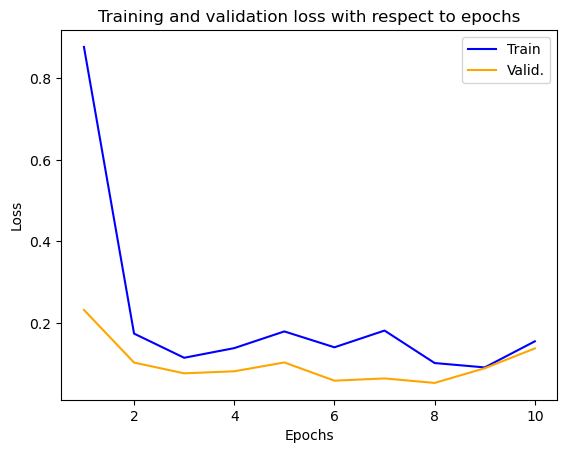

In [37]:
epochs = [x + 1 for x in range(len(train_loss))]
plt.plot(epochs, train_loss, color = "blue")
plt.plot(epochs, valid_loss, color = "orange")

plt.title("Training and validation loss with respect to epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend(["Train", "Valid."])

plt.show()

##### 7.2.3.2 Mesure

In [38]:
from torchtext.data.metrics import bleu_score

"""
    : @param predictions :
    : @param targets     :
    : @return BLEU       :
entrées:
       - predictions: Liste des prédicitons du modèle pour l'ensemble de validation. Chaque prédiction est une liste de jetons textuels.
       - targets: Liste des requêtes attendues de l'ensemble de validation. Chaque requête est une liste de jetons textuels.
    sortie: 
       Le score bleu moyen de vos prédictions comparées aux requêtes attendues.
"""

def compute_bleu(predictions, targets) :
    return bleu_score(predictions, [[tokens] for tokens in targets])

In [39]:
predicted_tokens = []

for i, tokens in enumerate(tqdm(valid["tokens"])) :
    lookup = valid["lookup"].iloc[i]
    translation, attention = translate_sentence(tokens, SRC, TRG, model, device)
    translation = postprocess(translation, lookup)
    predicted_tokens.append(translation.split())

100%|██████████| 500/500 [01:18<00:00,  6.38it/s]


In [40]:
target_tokens = [x.split() for x in valid['sparql']]

for i in range(5) :
    print(predicted_tokens[i])
    print(target_tokens[i])
    print()

['select', 'distinct', '?uri', 'where', '{', '?x', 'dbp:international', 'dbr:Muslim_Brotherhood', '.', '?x', 'dbo:religion', '?uri', '.', '?x', 'rdf:type', 'dbo:PoliticalParty', '}']
['select', 'distinct', '?uri', 'where', '{', '?x', 'dbp:international', 'dbr:Muslim_Brotherhood', '.', '?x', 'dbo:religion', '?uri', '.', '?x', 'rdf:type', 'dbo:PoliticalParty', '}']

['select', 'distinct', '?uri', 'where', '{', 'dbr:Sam_Loyd', 'dbo:knownFor', '?uri', '.', 'dbr:Eric_Schiller', 'dbo:knownFor', '?uri', '.', '}']
['select', 'distinct', '?uri', 'where', '{', 'dbr:Sam_Loyd', 'dbo:knownFor', '?uri', '.', 'dbr:Eric_Schiller', 'dbo:knownFor', '?uri', '.', '}']

['select', 'distinct', '?uri', 'where', '{', 'dbr:Joe_Pass', 'dbo:associatedBand', '?uri', '.', 'dbr:Dream_Dancing_(album)', 'dbp:artist', '?uri', '}']
['select', 'distinct', '?uri', 'where', '{', 'dbr:Joe_Pass', 'dbo:associatedBand', '?uri', '.', 'dbr:Dream_Dancing_(album)', 'dbp:artist', '?uri', '.', '}']

['select', 'distinct', '?uri', '

In [41]:
bleu_score = compute_bleu(predicted_tokens, target_tokens)
print(f"Le score BLEU est de : {bleu_score:2.5f}")

Le score BLEU est de : 0.93733


In [42]:
from sklearn.metrics import accuracy_score

text_predictions = [" ".join(tokens) for tokens in predicted_tokens]
text_targets = valid["sparql"].tolist()

accuracy = accuracy_score(text_targets, text_predictions)
print(f"La précision globale est de : {accuracy:2.5f}")

example_id = random.randint(0, len(text_predictions))
print("Exemple: ")
print(f"ID: {example_id}")
print(f"Gold       : {text_targets[example_id]}")
print(f"Prediction : {text_predictions[example_id]}")

La précision globale est de : 0.77600
Exemple: 
ID: 432
Gold       : select distinct ?uri where { ?x dbp:sisterStations dbr:Al_Arabiya_99 . ?x dbp:location ?uri . ?x rdf:type dbo:RadioStation }
Prediction : select distinct ?uri where { ?x dbp:sisterStations dbr:Al_Arabiya_99 . ?x dbp:location ?uri . ?x rdf:type dbo:RadioStation }


##### 7.2.3.3 Soumission

In [43]:
submissions = []

for i, tokens in enumerate(tqdm(test["tokens"])) :
    lookup = test["lookup"].iloc[i]
    translation, attention = translate_sentence(tokens, SRC, TRG, model, device)
    translation = postprocess(translation, lookup)
    submissions.append(translation)

100%|██████████| 500/500 [01:16<00:00,  6.51it/s]


In [44]:
import csv

def write_submissions_to_csv(file_path, submissions) :
    file = open(file_path, "w", encoding = "utf-8", newline = "")
    

    writer = csv.writer(file)
    header = ['id', 'translation']
    writer.writerow(header)

    for id, submission in enumerate(submissions):
        row = [id, submission]
        writer.writerow(row)

    file.close()

write_submissions_to_csv(f"{PATH}/tp4_submission.csv", submissions)

### 7.3. Approche(s) avancée(s) (30%)

Reprenez les étapes de la partie précédente avec une ou plusieurs nouvelle(s) architecture(s) plus complexe(s), ou améliorant votre précédente architecture, afin d’obtenir un score plus élevé sur l’ensemble de validation et dans la compétition Kaggle. Démontrez bien cette amélioration dans votre notebook.

#### 7.3.1. Rechargement des données brutes

In [45]:
# Chargement des fichiers d'entraînement et de tests.
train = pandas.read_csv(PATH + "train.csv")
valid = pandas.read_csv(PATH + "validation.csv")
test = pandas.read_csv(PATH + "test.csv")

#### 7.3.2. Importation de modèles pré-entraînés

In [46]:
%%capture

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained('t5-base', model_max_length = 512)
model = AutoModelForSeq2SeqLM.from_pretrained('t5-base')

#### 7.3.3. Pré-traitement

In [51]:
# Expressions that are similar in sense can be replaced by a single token
# N.B. Expressions have been hand selected due to time constraints but
# semantic analysis could be performed and would be preferable on more
# complicated datasets
expressions = {
    "count the " : "<how_many> ",
    "give me a count of " : "<how_many> ",
    "give me the total of " : "<how_many> ",
    "how many " : "<how_many> ",
    "what is the number of " : "<how_many> ",
    "what is the total number of " : "<how_many> ",
    "list the " : "<list> ",
    "what are " : "<what> ",
    "what is " : "<what> ",
    "who are the " : "<who> ",
    "who is the " : "<who> "
}

In [52]:
"""
    Fonction qui transforme un dataframe de chaînes de caractères en liste de
    jetons.
    
    Les étapes de pré-traitement à compléter sont les suivantes :
    1. Enlever les majuscules
    2. Enlever les caractères de ponctuations
    3. Séparer la chaine de caractères en une liste de jetons (tokenization) 
    4. Enlever les stopwords
    5. Stemming (racinisation)
    
    : @param df_input          : Le Dataframe à traiter
    : @param cols              : Liste de strings contenant les noms des colonnes à traiter
    : @param removeStopwords   : Si les stopwords doivent être retirés
    : @param stemming          : Si la racinisation doit être appliquée
    : @param charPunctuation   : Si la ponctuation attendue d'une requête SPARQL
                                 doit être convertie en tokens textuels
    : @param keywordReplace    : Si les mots clés d'une requête SPARQL doivent
                                 être convertis en tokens textuels
    : @param expressionReplace : Si les expressions doivent être converties
                                 en tokens symboliques
    : @return df               : Dataframe contenant les listes de jetons pré-traités
    : @return lookup           : Dictionnaires de traduction des tokens protégés
"""
def prepocessDataframeCols(df_input, cols, removeStopwords = False, stemming = False, charPunctuation = False,
                           keywordReplace = False, expressionReplace = False) :
    df = df_input[cols].copy(deep = True)
    
    # Retire les symboles de ponctuation associés aux tokens SPARQL qui vont être créés
    df = df.replace("[<>]", "", regex = True)
    
    if(expressionReplace) :
        for col in cols :
            for exp in expressions.keys() :
                df[col] = df[col].str.replace(exp, expressions[exp])
    
    df, lookup = SPARQL_tokens(df_input, cols, charPunctuation = charPunctuation, keywordReplace = keywordReplace)
    
    for col in cols :
        # Retire les majuscules
        df[col] = df[col].str.lower()
        
        # Retire la ponctuation en la remplaçant par des espaces et
        # en retirant ensuite les espaces doubles
        if(col == "sparql") :
            if(charPunctuation) :
                df[col] = df[col].str.replace("[^A-Za-z0-9<>_]", " ")
            else :
                df[col] = df[col].str.replace("[^A-Za-z0-9{}.<>_]", " ")
                df[col] = df[col].str.replace("([{}.])", " \g<1> ")
        else :
            df[col] = df[col].str.replace("[^A-Za-z0-9<>_]", " ")
        
        df[col] = df[col].str.replace("[ ]+", " ")
        
        # Sépare en jetons selon les espaces
        df[col] = df[col].str.split()
        
        if(removeStopwords or stemming) :
            for i in range(len(df[col])) :
                tokens = df[col].iloc[i]
                if(removeStopwords) :
                    filtered_tokens = []
                    for token in tokens :
                        if token not in stopwords :
                            filtered_tokens = filtered_tokens + [token]
                    
                    tokens = filtered_tokens
                
                if(stemming) :
                    tokens = [stemmer.stem(token) for token in tokens]
                
                df[col].iloc[i] = tokens
    
    return df, lookup

In [53]:
# On applique la fonction de prétraitement aux ensembles de données
cols = ["english", "sparql"]
tokens, lookup = prepocessDataframeCols(train, cols, charPunctuation = True, keywordReplace = True, expressionReplace = True)
train["tokens"] = tokens["english"]
train["request"] = tokens["sparql"]
train["lookup"] = lookup["lookup"]

joinTokens(tokens, cols).to_csv(PATH + "train_tokens.csv")

tokens, lookup = prepocessDataframeCols(valid, cols, charPunctuation = True, expressionReplace = True)
valid["tokens"] = tokens["english"]
valid["request"] = tokens["sparql"]
valid["lookup"] = lookup["lookup"]

joinTokens(tokens, cols).to_csv(PATH + "valid_tokens.csv")

cols = ["english"]
tokens, lookup = prepocessDataframeCols(test, cols, charPunctuation = True, expressionReplace = True)
test["tokens"] = tokens["english"]
test["lookup"] = lookup["lookup"]

joinTokens(tokens, cols).to_csv(PATH + "test_tokens.csv")

In [ ]:
PREFIX = ["dbr", "dbo", "dbp", "rdf"]
VAR_TOKEN = { "dbr": "<DBR_", "dbo": "<DBO_", "dbp": "<DBP_", "rdf": "<RDF_" }
ENG_KEYWORDS = expressions
SPARQL_KEYWORDS = SPARQL_reserved_keywords + SPARQL_punctuation + var + parentheses
SPARQL_TO_ENG = SPARQL_translation_dict + var + parentheses

VARIABLE_TOKENS = []
SPECIAL_TOKENS = []

for var_type in VAR_TOKEN.keys():
    for i in range(5):
        token_name = f"{VAR_TOKEN[var_type]}{i}>"
        VARIABLE_TOKENS.append(token_name)
        SPECIAL_TOKENS.append(token_name)

for token_name in SPARQL_TO_ENG.keys():
    SPECIAL_TOKENS.append(token_name)

for token_name in ENG_KEYWORDS.values():
    if token_name not in SPECIAL_TOKENS:
        SPECIAL_TOKENS.append(token_name)

In [ ]:
# Identification des variables
def is_variable(token):
    """
    Identifie les variables de type dbo:abc, dbp:aaa, ...
    """
    return len(token) > 4 and (token[:3] in PREFIX and token[3] == ':')

def is_token_variable(token):
    """
    Identifie les variables de type <DBO_1>, <DBP_1>, ...
    """
    return token in VARIABLE_TOKENS

def identify_variables(tokens: list):
    variables = { "dbr": [], "dbo": [], "dbp": [], "rdf": [] }

    for i, token in enumerate(tokens):
        if is_variable(token):
            var_type = token[:3]
            variables[var_type].append(token)

    return variables

In [ ]:
# Definition des variables de chaque texte.
VARIABLES_DICT_TRAIN = []
VARIABLES_DICT_VALIDATION = []

def create_var_dict(var_dict, df):
    for sentence in df['english']:
        words = sentence.split()
        variables = identify_variables(words)
        var_dict.append(variables)

    for sentence_id, sentence in enumerate(df['sparql']):
        words = sentence.split()
        variables = identify_variables(words)
        for var_type in variables.keys():
            for i, var_name in enumerate(variables[var_type]):
                if var_name not in var_dict[sentence_id][var_type]:
                    var_dict[sentence_id][var_type].append(var_name)

create_var_dict(VARIABLES_DICT_TRAIN, train_df)
create_var_dict(VARIABLES_DICT_TRAIN, validation_df)
create_var_dict(VARIABLES_DICT_VALIDATION, validation_df)

In [ ]:
# TODO
def preprocess(tokens: list, var_dict):
    for i, token in enumerate(tokens):
        if is_variable(token):
            var_type = token[:3]
            for idx, var in enumerate(var_dict[var_type]):
                if var == token:
                    tokens[i] = f"{VAR_TOKEN[var_type]}{idx}>"

    tokens = " ".join(tokens)
    for expression in ENG_KEYWORDS.keys():
        tokens = tokens.replace(expression, ENG_KEYWORDS[expression])
            
    return tokens.split()

def train_preprocess(tokens: list):
    id = 0
    for i, token in enumerate(tokens):
        if i == 0 and token.isnumeric():
            id = int(token)
        if is_variable(token):
            var_type = token[:3]
            for idx, var in enumerate(VARIABLES_DICT_TRAIN[id][var_type]):
                if var == token:
                    tokens[i] = f"{VAR_TOKEN[var_type]}{idx}>"
            
    tokens = " ".join(tokens)
    for expression in ENG_KEYWORDS.keys():
        tokens = tokens.replace(expression, ENG_KEYWORDS[expression])

    tokens = tokens.split()

    return tokens[1:]

def preprocess_sparql(tokens: list, var_dict):
    tokens = preprocess(tokens, var_dict)
    for i, token in enumerate(tokens):
        if token in SPARQL_KEYWORDS:
            tokens[i] = SPARQL_KEYWORDS[token]
        
    return tokens

def train_preprocess_sparql(tokens: list):
    id = 0
    for i, token in enumerate(tokens):
        if i == 0 and token.isnumeric():
            id = int(token)
        if is_variable(token):
            var_type = token[:3]
            for idx, var in enumerate(VARIABLES_DICT_TRAIN[id][var_type]):
                if var == token:
                    tokens[i] = f"{VAR_TOKEN[var_type]}{idx}>"

    for i, token in enumerate(tokens):
        if token in SPARQL_KEYWORDS:
            tokens[i] = str(SPARQL_KEYWORDS[token])
            
    return tokens[1:]

In [ ]:
from datasets import Dataset

preprocessed_train = train.copy(deep = True)
for i in range(len(preprocessed_train)) :
    lookup = VARIABLES_DICT_TRAIN[i]
    preprocessed_train["english"][i] = " ".join(preprocess(preprocessed_train["english"][i].split(), lookup))
    preprocessed_train["sparql"][i] = " ".join(preprocess_sparql(preprocessed_train["sparql"][i].split(), lookup))

preprocessed_valid = valid.copy(deep = True)
for i in range(len(preprocessed_valid)) :
    lookup = VARIABLES_DICT_VALID[i]
    preprocessed_valid["english"][i] = " ".join(preprocess(preprocessed_valid["english"][i].split(), lookup))
    preprocessed_valid["sparql"][i] = " ".join(preprocess_sparql(preprocessed_valid["sparql"][i].split(), lookup))

train = Dataset.from_pandas(preprocessed_train, split = "train")
valid = Dataset.from_pandas(preprocessed_valid, split = "validation")

In [ ]:
num_added_toks = tokenizer.add_tokens(SPECIAL_TOKENS, special_tokens = False) ##This line is updated
model.resize_token_embeddings(len(tokenizer))

In [ ]:
source_lang = "english"
target_lang = "sparql"

def preprocess_function(row) :
    inputs = row[source_lang]
    targets = row[target_lang]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

train_preprocessed = train_ds.map(preprocess_function, batched=True)
validation_preprocessed = validation_ds.map(preprocess_function, batched=True)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

#### 7.3.4. Entraînement

In [ ]:
import numpy
from torchtext.data.metrics import bleu_score

def postprocess_text(preds, labels):
    """
    preds = [(pred.strip().replace(".", " .").replace("?", " ?").replace("<", " <")).split() for pred in preds]
    labels = [[(label.strip().replace(".", " .").replace("?", " ?").replace("<", " <")).split()] for label in labels]
    """
    preds = [pred.strip().replace("<", " <").split() for pred in preds]
    labels = [[label.strip().replace("<", " <").split()] for label in labels]
    

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = numpy.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    print(f"PRED: {decoded_preds}")
    print(f"LABELS: {decoded_labels}")
    
    result = {}
    result = bleu_score(decoded_preds, decoded_labels)
    result = {"bleu": result}
    

    prediction_lens = [numpy.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = numpy.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="my_awesome_opus_books_model",
    evaluation_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=12,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_preprocessed,
    eval_dataset=validation_preprocessed,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

#### 7.3.5. Évaluation sur l'ensemble de validation

In [ ]:
# POST PROCESS
test_eng_1 = "0 select distinct count ( ?uri ) where { ?uri dbo:director dbr:Stanley_Kubrick . }"
test_tokens_1 = train_preprocess_sparql(test_eng_1.split())

def postprocess(token_list: list, var_dict: dict):
    for i, token in enumerate(token_list):
        if is_token_variable(token):
            var_type = token[1:4].lower()
            if var_type == "rdf":
                token_list[i] = "rdf:type"
            else:
                var_number = token.split("_")[1][:-1]
                if var_number.isnumeric() and len(var_dict[var_type]) > int(var_number):
                    token_list[i] = var_dict[var_type][int(var_number)]

    for i, token in enumerate(token_list):
        if token == "uri":
            token_list[i] = "?uri"
        if token in SPARQL_TO_ENG:
            token_list[i] = SPARQL_TO_ENG[token]

    return " ".join(token_list)

assert(postprocess(test_tokens_1, VARIABLES_DICT_TRAIN[0]) == test_eng_1[2:])

In [ ]:
def assign_random_tokens(token_list: list, variables: dict):
    # Récupérer toutes les variables identifiées dans la phrase en anglais.
    variables_list = []
    for var_type in variables.keys():
        for var in variables[var_type]:
            variables_list.append(var)

    # Retirer toutes les variables traduites en SPARQL.
    for token in token_list:
        if is_variable(token) and token in variables_list:
            variables_list.remove(token)

    # Assigner une variable non utilisée à un token non identifié.
    for i, token in enumerate(token_list):
        if is_token_variable(token):
            if len(variables_list) > 0:
                unused_var = variables_list.pop()
                token_list[i] = unused_var
            else:
                token_list[i] = ''

    output = []
    for t in token_list:
        if t != '':
            output.append(t)

    return output

translated_text = ['select', 'distinct', 'dbo:director', 'dbr_0']
assign_random_tokens(translated_text, VARIABLES_DICT_TRAIN[0])

In [ ]:
import random
import re

random_test_id = random.randint(0, len(train))
text = train['english'][random_test_id]
print(f"Sentence to translate: {text}\n")

def translate(text, variables_dict):
    inputs = tokenizer(text, return_tensors="pt").input_ids.to(device)
    outputs = model.to(device).generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
    raw_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    raw_text = raw_text.strip().replace(".", " .").replace("?", " ?").replace("<", " <")
    processed_text = postprocess(raw_text.split(), variables_dict)
    processed_text = assign_random_tokens(processed_text.split(), variables_dict)
    return " ".join(processed_text)

print(f"Translation: {translate(text, VARIABLES_DICT_TRAIN[random_test_id])}")
print(f"Gold passage: {train['sparql'][random_test_id]}")

In [ ]:
from tqdm import tqdm

predicted_texts = []
for i, text in enumerate(tqdm(valid['english'])):
    translation = translate(text, VARIABLES_DICT_VALID[i])
    predicted_texts.append(translation)

In [ ]:
target_texts = []
for text in tqdm(validation_df['sparql']):
    target_texts.append(text)

In [ ]:
from sklearn.metrics import accuracy_score

print(f"Accuracy: {accuracy_score(target_texts, predicted_texts)}")

#### 7.3.6. Soumission

In [ ]:
submissions = []
for i, text in enumerate(tqdm(test_df['english'])) :
    translation = translate(text, VARIABLES_DICT_TEST[i])
    submissions.append(translation)

In [ ]:
write_submissions_to_csv(f"{ROOT}/tp4_submission.csv", submissions)

### 7.4. Conclusion (5%)

En quelques phrases précises, discutez des avantages et limites de vos architectures. Analysez les cas d’erreur. Indiquez des pistes d’amélioration futures potentielles.

Dans la **section 7.2**, nous avons réalisé une architecture de type encodeur-décodeur avec un CNN. Le majeur inconvénient à cette architecture est qu'elle n'est pas très généralisable. Elle est conçue pour faire des tâches très précises. Si on introduisait des nouveaux types de questions, il est fort probable que les résultats seraient moins performants. Toutefois, ce modèle a donné des performances satisfaisantes. En effet, c'est le modèle de cette section qui a donné le meilleur score sur l'ensemble de test. Grâce aux étapes de pré-traitement, nous avons pu réduire la taille du vocabulaire en associant chaque variable à un jeton identifiant. Ainsi, cela a réduit les chances de générer un jeton malformé.

Les principales erreurs étaient dues à des séparateurs (*.*) ou des variables de type (*rdf*) omis. Ces erreurs

Une piste d'améliorer serait d'analyser la nature de la question est d'ajouter une étape de classification pour ensuite entraîner des réseaux de neurones spécifiques au type de question. Par exemple, on pourrait entraîner un réseau pour une question qui demande une quantité et un autre pour les questions qui demandent d'identifier un individu. Il faudrait toutefois que cette classification soit effectuée avec une très grande certitude.

Dans la **section 7.3**, nous avons tenté de concevoir un modèle amélioré en utilisant des modèles pré-entraînés et en entraînant des *transformers*. La principale force de cette approche est qu'elle est souvent utilisée dans des problèmes de séquence à séquence comme la traduction. Par conséquent, il existe plusieurs modèles pré-entraînés dans l'état de l'art pour des tâches générales. Cependant, nous n'avons pas obtenu de très bons résultats, notamment parce que nous devions générer des traductions vers une langue nouvelle au modèle. La quasi-totalité des jetons générés étaient nouveaux car, à cause du pré-traitement, nous avons associé chaque mot-clé en SPARQL à un nouveau jeton spécial. L'usage de modèles pré-entraînés ne nous a donc pas été très utile. 

Nous avons tenté d'implémenter les modèles pré-entraînés sans le pré-traitement, mais les résultats n'ont pas été satisfaisants. Très souvent, les jetons étaient malformés. À cause de la segmentation par séquences de caractères, les noms de variables étaient souvent complexes.

Des erreurs de tout type étaient observables. Des fois, les types de variables étaient mal identifiés. Par exemple, le modèle devait générer une variable *dbp* mais a prédit une variable *dbo*. 

## 8. LIVRABLES

Vous devez remettre sur Moodle:

1) Le code : Un Jupyter notebook en Python qui contient le code tel que soumis dans l’environnement Kaggle implanté avec les librairies disponibles pour ce cours (Python, Keras, NLTK, scikitLearn, etc.) ainsi que votre fichier de soumission de données de test. Le code doit être exécutable sans erreur et accompagné des commentaires appropriés dans le notebook de manière à expliquer les différentes fonctions et étapes dans votre projet. Nous nous réservons le droit de demander une démonstration ou la preuve que vous avez effectué vous-mêmes les expériences décrites. *Attention, en aucun cas votre code ne doit avoir été copié de projets potentiellement existants.*

2) Un fichier `requirements.txt` doit indiquer toutes les librairies / données nécessaires. Les critères de qualité tels que la lisibilité du code et des commentaires sont importants. 

3) Un lien *GoogleDrive* vers les modèles nécessaires pour exécuter votre notebook si approprié.

4) Le fichier `tp4_submission.csv`.

5) Un document `contributions.txt` : Décrivez brièvement la contribution de chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. En particulier, tous les membres du projet devraient participer à la conception du projet et participer activement à la réflexion et à l’implémentation du code.

__EVALUATION__ <br>
Votre TP sera évalué sur les points suivants :

__Critères :__ 
1. Implantation correcte et efficace
2. Exécution correcte du code
3. Qualité du code
4. Commentaires clairs et informatifs
5. Aspect novateur : autres métriques ou modèles qui dépassent ce qui est demandé

__CODE D’HONNEUR__
- __Règle 1__:  Le plagiat de code est bien évidemment interdit. Toute utilisation de code doit être référencée adéquatement. L’utilisation de code ne peut concerner que les architectures de base (par exemple le Transformer). Vous __ne pouvez pas__ soumettre un code, écrit par quelqu’un d’autre, faisant de la traduction de la langue naturelle vers SPARQL. Dans le cas contraire, cela sera considéré comme du plagiat. 
- __Règle 2__: Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe INF8460, ou incorporer leur code dans votre TP.
- __Règle 3__:  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.